# Ground-truth evaluation for KITTI sequences 01 & 02

This notebook evaluates our sparse-motion detector and Kalman tracker against the bounding boxes and depths provided in the KITTI tracking labels (sequences 01 & 02).

We reuse the detector/tracker components from the repository, and leverage the ground-truth annotations to compute detection metrics, depth accuracy, and simple tracking diagnostics.

In [1]:
import sys
from pathlib import Path
from collections import defaultdict

import cv2
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../src")

from kitti_io.loader import SequenceLoader, load_labels
from detection.sparse_motion import SparseMotionDetector
from tracking.kalman import MultiObjectTracker
from visualization.bbox_utils import draw_bounding_boxes
from detection.optical_flow import OpticalFlowDetector


In [6]:
# Evaluation configuration
SEQ_LIST = [
    "../data_rect/seq_01",
    "../data_rect/seq_02",
]
MAX_FRAMES = 200          # limit per sequence for speed (None = full sequence)
IOU_THRESHOLD = 0.5
SAMPLE_FRAME_COUNT = 6

STEREO_BASELINE = 0.54    # in meters, KITTI setup
STEREO_FOCAL = 721.0      # approx focal length in pixels
STEREO_PARAMS = dict(
    minDisparity=0,
    numDisparities=128,
    blockSize=15,
    P1=8 * 3 * 15 ** 2,
    P2=32 * 3 * 15 ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32,
)

DETECTOR_FACTORIES = {
    "sparse_motion": lambda: SparseMotionDetector(),
    "optical_flow": lambda: OpticalFlowDetector(
        motion_threshold=1.3,
        dbscan_eps=18,
        dbscan_min_samples=5,
        min_box_area=100,
    ),
}


In [7]:
def build_gt_index(labels_df):
    gt = defaultdict(list)
    if labels_df is None:
        return gt
    for row in labels_df.itertuples():
        bbox = [row.bbox_left, row.bbox_top, row.bbox_right, row.bbox_bottom]
        gt[row.frame].append({
            "track_id": int(row.track_id),
            "label": row.type,
            "bbox": bbox,
            "depth": float(row.loc_z),
        })
    return gt


def compute_iou(box_a, box_b):
    xA = max(box_a[0], box_b[0])
    yA = max(box_a[1], box_b[1])
    xB = min(box_a[2], box_b[2])
    yB = min(box_a[3], box_b[3])

    inter_w = max(0.0, xB - xA)
    inter_h = max(0.0, yB - yA)
    inter = inter_w * inter_h
    if inter == 0:
        return 0.0

    area_a = (box_a[2] - box_a[0]) * (box_a[3] - box_a[1])
    area_b = (box_b[2] - box_b[0]) * (box_b[3] - box_b[1])
    return inter / float(area_a + area_b - inter + 1e-6)


def match_predictions(pred_boxes, gt_objs, iou_thr=0.5):
    matches = []
    used_gt = set()
    used_pred = set()

    for pred_idx, box in enumerate(pred_boxes):
        best_iou = 0.0
        best_gt = -1
        for gt_idx, gt in enumerate(gt_objs):
            if gt_idx in used_gt:
                continue
            iou = compute_iou(box, gt["bbox"])
            if iou > best_iou:
                best_iou = iou
                best_gt = gt_idx
        if best_gt >= 0 and best_iou >= iou_thr:
            matches.append((pred_idx, best_gt, best_iou))
            used_gt.add(best_gt)
            used_pred.add(pred_idx)

    unmatched_pred = [i for i in range(len(pred_boxes)) if i not in used_pred]
    unmatched_gt = [i for i in range(len(gt_objs)) if i not in used_gt]
    return matches, unmatched_pred, unmatched_gt


def estimate_depths(disparity_map, boxes):
    depths = []
    h, w = disparity_map.shape
    for (x1, y1, x2, y2) in boxes:
        x1 = max(0, min(int(x1), w - 1))
        x2 = max(0, min(int(x2), w))
        y1 = max(0, min(int(y1), h - 1))
        y2 = max(0, min(int(y2), h))
        roi = disparity_map[y1:y2, x1:x2]
        if roi.size == 0:
            depths.append(None)
            continue
        valid = roi > 1.0
        if not np.any(valid):
            depths.append(None)
            continue
        disp = float(np.median(roi[valid]))
        depth = (STEREO_FOCAL * STEREO_BASELINE) / max(disp, 1e-3)
        depths.append(depth)
    return depths


In [8]:
def evaluate_sequence(seq_path, detector_factory, max_frames=None):
    seq_path = Path(seq_path)
    loader = SequenceLoader(str(seq_path), return_gray=False)
    labels_df = load_labels(str(seq_path / "labels.txt"))
    gt_index = build_gt_index(labels_df)

    detector = detector_factory()
    tracker = MultiObjectTracker(max_age=5, min_hits=2, iou_threshold=IOU_THRESHOLD)
    stereo = cv2.StereoSGBM_create(**STEREO_PARAMS)

    detection_stats = {"tp": 0, "fp": 0, "fn": 0}
    tracking_stats = {"tp": 0, "fp": 0, "fn": 0, "id_switches": 0}
    track_assignments = {}
    depth_errors = []
    samples = []
    frames_processed = 0

    for frame in loader:
        frame_id = frame["frame_id"]
        if max_frames is not None and frame_id >= max_frames:
            break

        frames_processed += 1
        left = frame["left"]
        right = frame["right"]
        gt_objs = gt_index.get(frame_id, [])

        boxes = detector.detect(left)
        gray_left = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
        gray_right = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
        disparity = stereo.compute(gray_left, gray_right).astype(np.float32) / 16.0
        pred_depths = estimate_depths(disparity, boxes)

        matches, unmatched_pred, unmatched_gt = match_predictions(boxes, gt_objs, IOU_THRESHOLD)
        detection_stats["tp"] += len(matches)
        detection_stats["fp"] += len(unmatched_pred)
        detection_stats["fn"] += len(unmatched_gt)

        for pred_idx, gt_idx, _ in matches:
            depth_pred = pred_depths[pred_idx]
            if depth_pred is None:
                continue
            depth_gt = gt_objs[gt_idx]["depth"]
            depth_errors.append(abs(depth_pred - depth_gt))

        tracks = tracker.update(boxes)
        track_boxes = [t["bbox"] for t in tracks]
        track_matches, track_unmatched, gt_unmatched = match_predictions(track_boxes, gt_objs, IOU_THRESHOLD)
        tracking_stats["tp"] += len(track_matches)
        tracking_stats["fp"] += len(track_unmatched)
        tracking_stats["fn"] += len(gt_unmatched)

        for pred_idx, gt_idx, _ in track_matches:
            track_id = tracks[pred_idx]["id"]
            gt_id = gt_objs[gt_idx]["track_id"]
            prev = track_assignments.get(track_id)
            if prev is None:
                track_assignments[track_id] = gt_id
            elif prev != gt_id:
                tracking_stats["id_switches"] += 1
                track_assignments[track_id] = gt_id

        if len(samples) < SAMPLE_FRAME_COUNT:
            samples.append({
                "frame_id": frame_id,
                "image": left.copy(),
                "pred_boxes": boxes.copy(),
                "gt_objs": gt_objs,
                "tracks": tracks,
                "pred_depths": pred_depths,
            })

    det_precision = detection_stats["tp"] / max(1, detection_stats["tp"] + detection_stats["fp"])
    det_recall = detection_stats["tp"] / max(1, detection_stats["tp"] + detection_stats["fn"])
    track_precision = tracking_stats["tp"] / max(1, tracking_stats["tp"] + tracking_stats["fp"])
    track_recall = tracking_stats["tp"] / max(1, tracking_stats["tp"] + tracking_stats["fn"])
    depth_mae = float(np.mean(depth_errors)) if depth_errors else None

    summary = {
        "frames_eval": frames_processed,
        "det_precision": det_precision,
        "det_recall": det_recall,
        "track_precision": track_precision,
        "track_recall": track_recall,
        "id_switches": tracking_stats["id_switches"],
        "depth_mae": depth_mae,
        "detections_tp": detection_stats["tp"],
        "detections_fp": detection_stats["fp"],
        "detections_fn": detection_stats["fn"],
    }
    return summary, samples


In [9]:
sequence_summaries = {name: {} for name in DETECTOR_FACTORIES}
sequence_samples = {name: {} for name in DETECTOR_FACTORIES}

for det_name, det_fn in DETECTOR_FACTORIES.items():
    print(f"=== Evaluating detector: {det_name} ===")
    for seq in SEQ_LIST:
        summary, samples = evaluate_sequence(seq, det_fn, max_frames=MAX_FRAMES)
        key = Path(seq).name
        sequence_summaries[det_name][key] = summary
        sequence_samples[det_name][key] = samples

        print(f"Sequence {key}")
        print(f"  Frames evaluated: {summary['frames_eval']}")
        print(f"  Detection precision/recall: {summary['det_precision']:.3f} / {summary['det_recall']:.3f}")
        print(f"  Tracking precision/recall: {summary['track_precision']:.3f} / {summary['track_recall']:.3f}")
        print(f"  ID switches: {summary['id_switches']}")
        if summary['depth_mae'] is not None:
            print(f"  Depth MAE: {summary['depth_mae']:.2f} m")
        else:
            print("  Depth MAE: n/a (no valid depth estimates)")
        print("  TP / FP / FN (detections): {} / {} / {}".format(
            summary['detections_tp'], summary['detections_fp'], summary['detections_fn']))
        print("-")


=== Evaluating detector: sparse_motion ===
Sequence seq_01
  Frames evaluated: 145
  Detection precision/recall: 0.062 / 0.066
  Tracking precision/recall: 0.063 / 0.086
  ID switches: 8
  Depth MAE: 0.31 m
  TP / FP / FN (detections): 58 / 874 / 825
-
Sequence seq_02
  Frames evaluated: 200
  Detection precision/recall: 0.054 / 0.022
  Tracking precision/recall: 0.042 / 0.026
  ID switches: 2
  Depth MAE: 4.55 m
  TP / FP / FN (detections): 68 / 1194 / 2982
-
=== Evaluating detector: optical_flow ===
Sequence seq_01
  Frames evaluated: 145
  Detection precision/recall: 0.091 / 0.052
  Tracking precision/recall: 0.182 / 0.065
  ID switches: 3
  Depth MAE: 0.87 m
  TP / FP / FN (detections): 46 / 458 / 837
-
Sequence seq_02
  Frames evaluated: 200
  Detection precision/recall: 0.109 / 0.029
  Tracking precision/recall: 0.105 / 0.035
  ID switches: 3
  Depth MAE: 2.39 m
  TP / FP / FN (detections): 88 / 716 / 2962
-


Visualization for sparse_motion | seq_01, frame 0


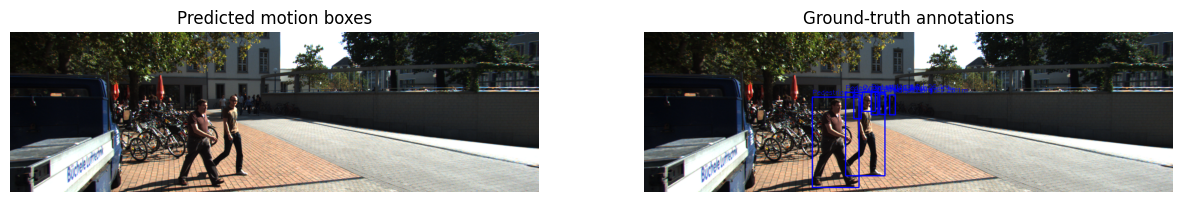

Visualization for sparse_motion | seq_02, frame 0


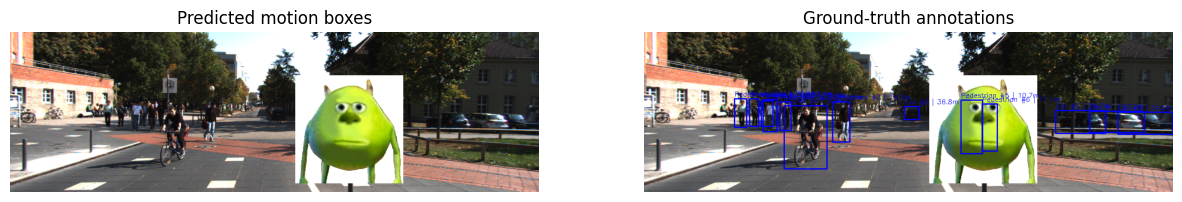

Visualization for optical_flow | seq_01, frame 0


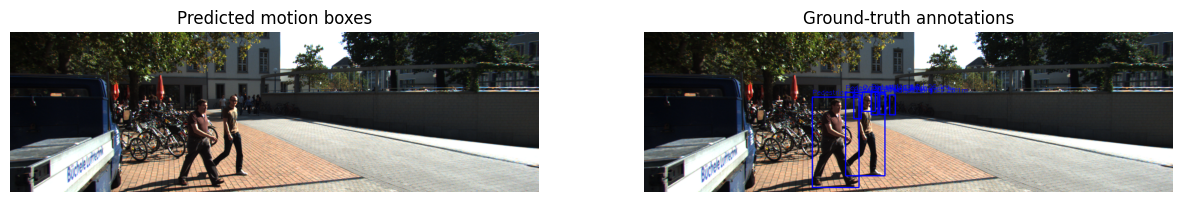

Visualization for optical_flow | seq_02, frame 0


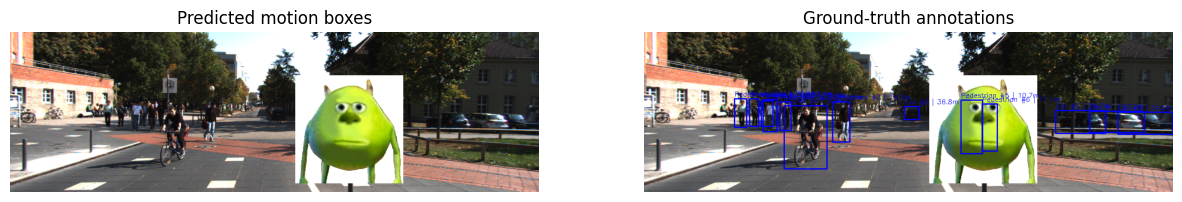

In [10]:
def visualize_sample(sample):
    frame = sample["image"].copy()
    pred_boxes = sample["pred_boxes"]
    gt_objs = sample["gt_objs"]
    vis_pred = draw_bounding_boxes(frame, pred_boxes, color=(0, 220, 0))
    vis_gt = frame.copy()
    for obj in gt_objs:
        x1, y1, x2, y2 = map(int, obj["bbox"])
        cv2.rectangle(vis_gt, (x1, y1), (x2, y2), (255, 0, 0), 2)
        label = f"{obj['label']} #{obj['track_id']} | {obj['depth']:.1f}m"
        cv2.putText(vis_gt, label, (x1, max(0, y1 - 6)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes[0].set_title("Predicted motion boxes")
    axes[0].imshow(cv2.cvtColor(vis_pred, cv2.COLOR_BGR2RGB))
    axes[0].axis("off")

    axes[1].set_title("Ground-truth annotations")
    axes[1].imshow(cv2.cvtColor(vis_gt, cv2.COLOR_BGR2RGB))
    axes[1].axis("off")
    plt.show()

for det_name, seq_samples in sequence_samples.items():
    for key, samples in seq_samples.items():
        if not samples:
            continue
        print(f"Visualization for {det_name} | {key}, frame {samples[0]['frame_id']}")
        visualize_sample(samples[0])
